# Demo: Spectrum Normalization and Peak Filtering
This notebook demonstrates the effects of the `SpectrumProcessor` on synthetic MS/MS spectra, using a variety of normalization and filtering options. It shows before/after numeric arrays and plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matchms import Spectrum
from yogimass.similarity.processing import SpectrumProcessor
plt.rcParams['figure.figsize'] = (7, 3)
print('Imports OK')

Imports OK


In [5]:
def plot_spectrum(spectrum: Spectrum, title: str = ''):
    mz = np.asarray(spectrum.peaks.mz)
    ints = np.asarray(spectrum.peaks.intensities)
    if mz.size == 0:
        print(title + ': (empty spectrum)')
        return
    plt.figure()
    plt.stem(mz, ints)
    plt.xlabel('m/z')
    plt.ylabel('intensity')
    plt.title(title)
    plt.grid(True)
    plt.show()

print('Helper loaded')

Helper loaded


In [3]:
def make_spectrum(mz, ints, dtype='float32', **meta):
    return Spectrum(mz=np.asarray(mz, dtype=dtype), intensities=np.asarray(ints, dtype=dtype), metadata=meta)

# Empty
s_empty = make_spectrum([], [])
# Noisy: primarily low-amplitude noise with a strong peak
s_noisy = make_spectrum([50, 60, 70], [0.01, 1.0, 0.005])
# Dense (many peaks of descending intensity)
mz_dense = np.linspace(100, 400, 500)
ints_dense = np.linspace(500, 1, mz_dense.size)
s_dense = make_spectrum(mz_dense, ints_dense)
# Duplicates around 150
s_dup = make_spectrum([150.0, 150.005, 151.0], [1.0, 2.0, 0.5])
# Negative intensities (invalid)
s_neg = make_spectrum([50], [-1.0])
print('Spectra created')

2025-12-11 20:20:04,500:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2025-12-11 20:20:04,501:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2025-12-11 20:20:04,501:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2025-12-11 20:20:04,502:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2025-12-11 20:20:04,502:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
Spectra created


Empty spectrum (before): (empty spectrum)


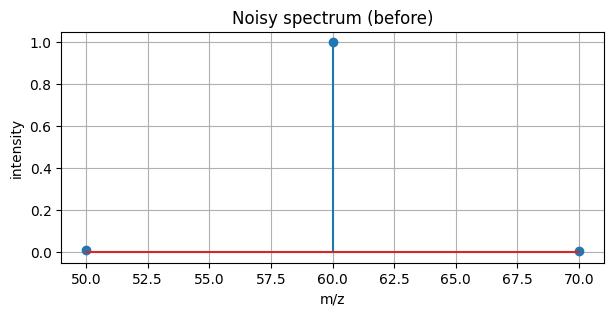

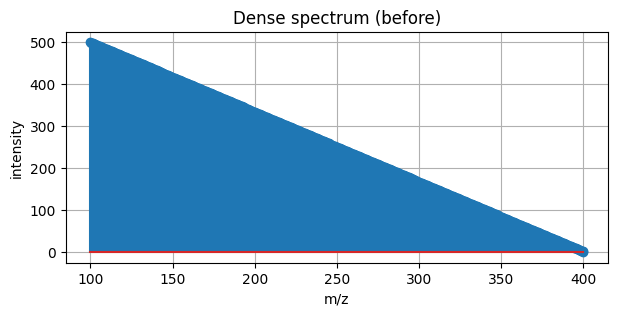

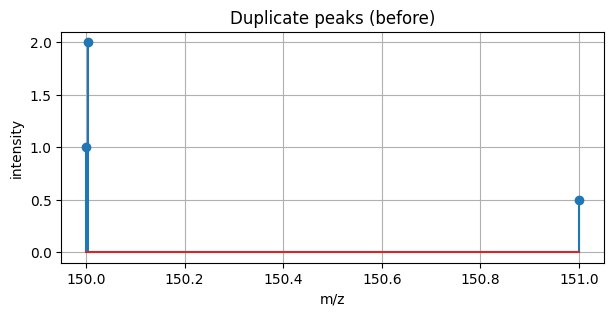

In [6]:
# Show before
plot_spectrum(s_empty, 'Empty spectrum (before)')
plot_spectrum(s_noisy, 'Noisy spectrum (before)')
plot_spectrum(s_dense, 'Dense spectrum (before)')
plot_spectrum(s_dup, 'Duplicate peaks (before)')

In [ ]:
# Apply normalization: TIC and BasePeak
p_tic = SpectrumProcessor(normalization='tic')
p_base = SpectrumProcessor(normalization='basepeak')
out_tic = p_tic.normalize(s_noisy)
out_base = p_base.normalize(s_noisy)
print('TIC-normalized intensities:', out_tic.peaks.intensities)
print('Basepeak-normalized intensities:', out_base.peaks.intensities)
plot_spectrum(out_tic, 'TIC normalized')
plot_spectrum(out_base, 'Basepeak normalized')

In [ ]:
# Apply filtering: remove low-intensity and keep top-N
p_filter = SpectrumProcessor(min_relative_intensity=0.05, min_absolute_intensity=0.01, max_peaks=5)
out_filtered = p_filter.filter_noise(s_dense)
print('Dense -> filtered #peaks:', len(out_filtered.peaks.mz))
plot_spectrum(out_filtered, 'Dense filtered (top-N)')
# Apply dedup + filter on duplicate peaks
p_dedup = SpectrumProcessor(min_relative_intensity=0.01, mz_dedup_tolerance=0.01)
out_dedup = p_dedup.filter_noise(s_dup)
print('Deduped mz:', out_dedup.peaks.mz)
print('Deduped intensities:', out_dedup.peaks.intensities)
plot_spectrum(out_dedup, 'Deduped (apex)')

In [ ]:
# Show error handling for negative intensities
p = SpectrumProcessor()
try:
    p.filter_noise(s_neg)
except Exception as e:
    print('filter_noise error (expected):', e)

try:
    p.normalize(s_neg)
except Exception as e:
    print('normalize error (expected):', e)

In [ ]:
# Verify invariants on a processed spectrum
p = SpectrumProcessor(normalization='basepeak', min_relative_intensity=0.02, max_peaks=10, float_dtype=np.float32)
proc = p.process(s_dense)
print('m/z dtype:', proc.peaks.mz.dtype)
print('intensity dtype:', proc.peaks.intensities.dtype)
print('sorted m/z?', np.all(np.diff(proc.peaks.mz) >= 0))
print('matching lengths?', len(proc.peaks.mz) == len(proc.peaks.intensities))
plot_spectrum(proc, 'Processed dense (invariants)')

In [ ]:
# Save outputs as numpy arrays (demonstration)
import os
os.makedirs('out', exist_ok=True)
np.save('out/s_noisy.npy', np.vstack((np.asarray(s_noisy.peaks.mz), np.asarray(s_noisy.peaks.intensities))))
np.save('out/s_noisy_processed.npy', np.vstack((np.asarray(proc.peaks.mz), np.asarray(proc.peaks.intensities))))
print('Saved to out/')

# Summary prints
print('Done: Completed demo processing')